# AAI-540 JUMBO NOTEBOOK (Modules 2–6) — Retail Forecasting

**Dataset:** Corporación Favorita (Kaggle) - Store Sales

**Location assumption:** you unzipped files into `aai-540-labs/data/`

**Files expected in ./data:**
- train.csv
- stores.csv
- oil.csv
- transactions.csv
- holidays_events.csv

## CELL 1 — Imports & Config

In [1]:
import os
import json
import time
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from datetime import datetime

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

import joblib

# For displaying DataFrames nicely in Jupyter
from IPython.display import display

DATA_DIR = "data"
ARTIFACT_DIR = os.path.join(DATA_DIR, "artifacts")
os.makedirs(ARTIFACT_DIR, exist_ok=True)

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

print("CWD:", os.getcwd())
print("DATA_DIR exists?", os.path.exists(DATA_DIR))
if os.path.exists(DATA_DIR):
    print("Files in data:", os.listdir(DATA_DIR)[:50])
else:
    print("WARNING: DATA_DIR does not exist. Please create it and add the required CSV files.")

CWD: /home/sagemaker-user/aai-540-labs
DATA_DIR exists? True
Files in data: ['holidays_events.csv', 'oil.csv', 'sample_submission.csv', 'stores.csv', 'test.csv', 'train.csv', 'transactions.csv', 'train_stores_merged.csv', 'train_oil_merged.csv', 'train_features.csv', 'val_features.csv', 'test_features.csv', 'prod_features.csv', 'engineered_train.csv', 'artifacts', 'monitoring_metrics.csv', 'drift_report.csv', 'processed_module3', 'prod_scored.csv', 'monitoring_drift_report.csv', 'monitoring_performance.json', 'cicd_gate.json']


## CELL 2 — Load Raw CSVs

In [2]:
train = pd.read_csv(os.path.join(DATA_DIR, "train.csv"), parse_dates=["date"])
stores = pd.read_csv(os.path.join(DATA_DIR, "stores.csv"))
oil = pd.read_csv(os.path.join(DATA_DIR, "oil.csv"), parse_dates=["date"])
transactions = pd.read_csv(os.path.join(DATA_DIR, "transactions.csv"), parse_dates=["date"])
holidays = pd.read_csv(os.path.join(DATA_DIR, "holidays_events.csv"), parse_dates=["date"])

print("train:", train.shape, "stores:", stores.shape, "oil:", oil.shape, "transactions:", transactions.shape, "holidays:", holidays.shape)
train.head()

train: (3000888, 6) stores: (54, 5) oil: (1218, 2) transactions: (83488, 3) holidays: (350, 6)


,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


## CELL 3 — OPTIONAL (Memory-safe sampling)

If your kernel dies, reduce `SAMPLE_ROWS`.

In [3]:
SAMPLE_ROWS = 200000   # Reduced for faster execution and memory safety
use_sample = True

if use_sample:
    train_work = train.sample(SAMPLE_ROWS, random_state=RANDOM_SEED)
else:
    train_work = train.copy()

print("train_work:", train_work.shape)

train_work: (200000, 6)


## CELL 4 — Basic Cleaning

In [4]:
# Keep sales non-negative; handle oil missing later
train_work["sales"] = train_work["sales"].clip(lower=0)

# Ensure onpromotion numeric
if "onpromotion" in train_work.columns:
    train_work["onpromotion"] = pd.to_numeric(train_work["onpromotion"], errors="coerce").fillna(0).astype(int)

## CELL 5 — Holiday features (National holidays only)

In [5]:
# Create a national holiday indicator by date
national_holidays = holidays[
    (holidays["locale"] == "National") &
    (holidays["transferred"] == False)
][["date"]].copy()

national_holidays["is_holiday"] = 1

print("national_holidays:", national_holidays.shape)
national_holidays.head()

national_holidays: (166, 2)


,date,is_holiday
14,2012-08-10,1
20,2012-10-12,1
21,2012-11-02,1
22,2012-11-03,1
31,2012-12-21,1


## CELL 6 — Merge to build a modeling table

In [6]:
df = train_work.merge(stores, on="store_nbr", how="left")
df = df.merge(oil, on="date", how="left")
df = df.merge(transactions, on=["date", "store_nbr"], how="left")
df = df.merge(national_holidays, on="date", how="left")

df["is_holiday"] = df["is_holiday"].fillna(0).astype(int)

# oil sometimes missing -> forward fill by date (global)
df = df.sort_values("date")
df["dcoilwtico"] = df["dcoilwtico"].ffill()

# transactions missing -> fill 0
df["transactions"] = df["transactions"].fillna(0)

print("Merged df:", df.shape)
df.head()

Merged df: (200462, 13)


,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico,transactions,is_holiday
132032,1344,2013-01-01,46,MEATS,0.0,0,Quito,Pichincha,A,14,NaN,0.0,1
170586,567,2013-01-01,25,CELEBRATION,0.0,0,Salinas,Santa Elena,D,1,NaN,770.0,1
34820,1145,2013-01-01,40,MAGAZINES,0.0,0,Machala,El Oro,C,3,NaN,0.0,1
153784,29,2013-01-01,1,PREPARED FOODS,0.0,0,Quito,Pichincha,D,13,NaN,0.0,1
35191,434,2013-01-01,21,BREAD/BAKERY,0.0,0,Santo Domingo,Santo Domingo de los Tsachilas,B,6,NaN,0.0,1


## CELL 7 — Time features

In [7]:
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month
df["day"] = df["date"].dt.day
df["weekday"] = df["date"].dt.weekday
df["week"] = df["date"].dt.isocalendar().week.astype(int)

# A couple of basic target transforms/controls
df["log_sales"] = np.log1p(df["sales"])

df[["date","store_nbr","family","sales","onpromotion","dcoilwtico","transactions","is_holiday","month","weekday"]].head()

,date,store_nbr,family,sales,onpromotion,dcoilwtico,transactions,is_holiday,month,weekday
132032,2013-01-01,46,MEATS,0.0,0,NaN,0.0,1,1,1
170586,2013-01-01,25,CELEBRATION,0.0,0,NaN,770.0,1,1,1
34820,2013-01-01,40,MAGAZINES,0.0,0,NaN,0.0,1,1,1
153784,2013-01-01,1,PREPARED FOODS,0.0,0,NaN,0.0,1,1,1
35191,2013-01-01,21,BREAD/BAKERY,0.0,0,NaN,0.0,1,1,1


## CELL 8 — Quick EDA plots (lightweight)

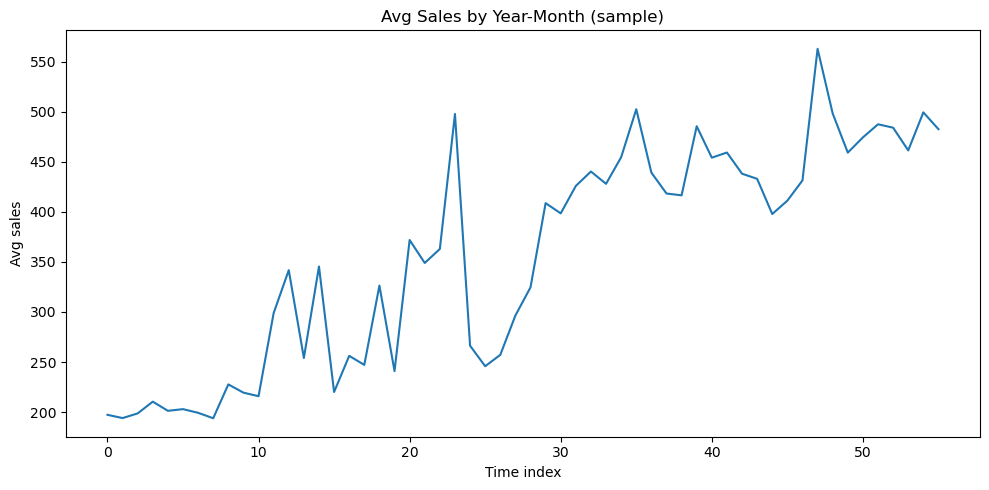

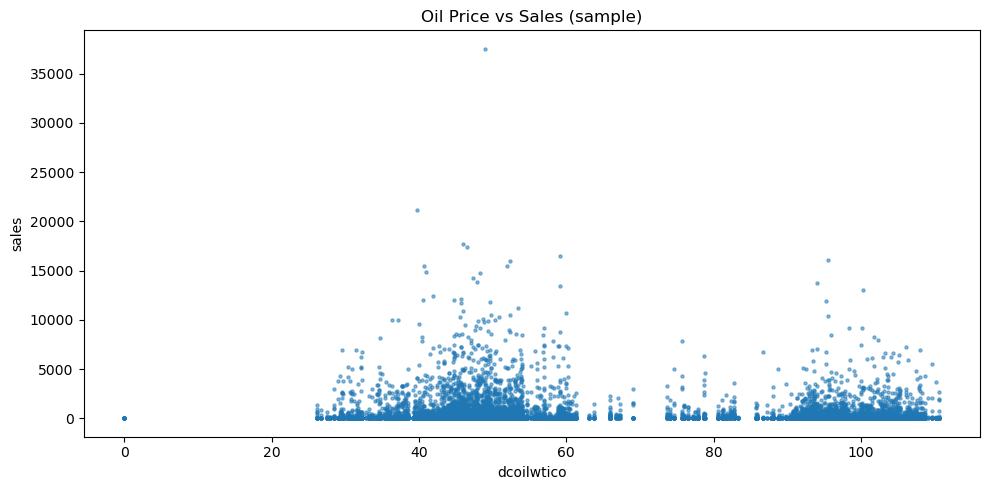

In [8]:
# Sales trend by month
tmp = df.groupby(["year","month"])["sales"].mean().reset_index()
plt.figure(figsize=(10, 5))
plt.plot(range(len(tmp)), tmp["sales"])
plt.title("Avg Sales by Year-Month (sample)")
plt.xlabel("Time index")
plt.ylabel("Avg sales")
plt.tight_layout()
plt.show()

# Oil vs sales scatter (small sample)
sample_scatter = df.sample(min(15000, len(df)), random_state=RANDOM_SEED)
plt.figure(figsize=(10, 5))
plt.scatter(sample_scatter["dcoilwtico"].fillna(0), sample_scatter["sales"], s=5, alpha=0.5)
plt.title("Oil Price vs Sales (sample)")
plt.xlabel("dcoilwtico")
plt.ylabel("sales")
plt.tight_layout()
plt.show()

## CELL 9 — Lag/rolling features (by store_nbr + family)

These can be heavy; keep sample size reasonable.

**Note:** This cell uses `.transform()` for the rolling mean to avoid index alignment issues.

In [9]:
df = df.sort_values(["store_nbr", "family", "date"])

df["sales_lag_7"] = df.groupby(["store_nbr","family"])["sales"].shift(7)
df["sales_lag_14"] = df.groupby(["store_nbr","family"])["sales"].shift(14)

# Rolling mean of previous sales (shifted by 1 to avoid leakage)
# Using transform with lambda to handle the groupby rolling correctly
df["sales_roll_mean_7"] = (
    df.groupby(["store_nbr","family"])["sales"]
    .transform(lambda s: s.shift(1).rolling(7, min_periods=1).mean())
)

# Fill NA as 0 (for early periods)
for c in ["sales_lag_7", "sales_lag_14", "sales_roll_mean_7"]:
    df[c] = df[c].fillna(0)

df[["date","store_nbr","family","sales","sales_lag_7","sales_roll_mean_7"]].head(15)

,date,store_nbr,family,sales,sales_lag_7,sales_roll_mean_7
65738,2013-02-20,1,AUTOMOTIVE,2.0,0.0,0.000000
159171,2013-03-07,1,AUTOMOTIVE,0.0,0.0,2.000000
71203,2013-03-25,1,AUTOMOTIVE,4.0,0.0,1.000000
180802,2013-04-21,1,AUTOMOTIVE,1.0,0.0,2.000000
132682,2013-05-24,1,AUTOMOTIVE,2.0,0.0,1.750000
78664,2013-06-23,1,AUTOMOTIVE,3.0,0.0,1.800000
127555,2013-06-27,1,AUTOMOTIVE,3.0,0.0,2.000000
127008,2013-06-29,1,AUTOMOTIVE,5.0,2.0,2.142857
8415,2013-08-05,1,AUTOMOTIVE,6.0,0.0,2.571429
61415,2013-08-08,1,AUTOMOTIVE,1.0,4.0,3.428571


## CELL 10 — Define modeling features (dynamic + safe)

In [10]:
candidate_features = [
    "store_nbr", "family",       # will encode
    "onpromotion","dcoilwtico","transactions","is_holiday",
    "year","month","day","weekday","week",
    "sales_lag_7","sales_lag_14","sales_roll_mean_7",
    # store metadata
    "city","state","type","cluster"
]

# keep only existing columns
FEATURES_RAW = [c for c in candidate_features if c in df.columns]
TARGET = "sales"
print("Using features:", FEATURES_RAW)

Using features: ['store_nbr', 'family', 'onpromotion', 'dcoilwtico', 'transactions', 'is_holiday', 'year', 'month', 'day', 'weekday', 'week', 'sales_lag_7', 'sales_lag_14', 'sales_roll_mean_7', 'city', 'state', 'type', 'cluster']


## CELL 11 — Encode categoricals

In [11]:
# Convert categoricals to category codes (simple & stable)
df_model = df.copy()

cat_cols = [c for c in ["family","city","state","type"] if c in df_model.columns]
for c in cat_cols:
    df_model[c] = df_model[c].astype("category")
    df_model[c] = df_model[c].cat.codes

# store_nbr is numeric but ensure int
df_model["store_nbr"] = df_model["store_nbr"].astype(int)

## CELL 12 — Time-based split (Module 3 requirement)

Train (~40%), Val (~10%), Test (~10%), Prod (~40%)

In [12]:
df_model = df_model.sort_values("date")

# Choose cutoffs by quantiles on time (not random)
dates_sorted = df_model["date"].sort_values().unique()
n = len(dates_sorted)

cut_train = dates_sorted[int(0.40*n)]
cut_val   = dates_sorted[int(0.50*n)]
cut_test  = dates_sorted[int(0.60*n)]

train_df = df_model[df_model["date"] <= cut_train].copy()
val_df   = df_model[(df_model["date"] > cut_train) & (df_model["date"] <= cut_val)].copy()
test_df  = df_model[(df_model["date"] > cut_val) & (df_model["date"] <= cut_test)].copy()
prod_df  = df_model[df_model["date"] > cut_test].copy()

print("Splits:")
print("train:", train_df.shape, train_df["date"].min(), train_df["date"].max())
print("val  :", val_df.shape,   val_df["date"].min(),   val_df["date"].max())
print("test :", test_df.shape,  test_df["date"].min(),  test_df["date"].max())
print("prod :", prod_df.shape,  prod_df["date"].min(),  prod_df["date"].max())

Splits:
train: (80214, 22) 2013-01-01 00:00:00 2014-11-06 00:00:00
val  : (20136, 22) 2014-11-07 00:00:00 2015-04-25 00:00:00
test : (20138, 22) 2015-04-26 00:00:00 2015-10-10 00:00:00
prod : (79974, 22) 2015-10-11 00:00:00 2017-08-15 00:00:00


## CELL 13 — Save Module 3 outputs (what later modules use)

In [16]:
# Save full features tables (lightweight, no huge raw columns)
keep_cols = ["id","date", TARGET] + FEATURES_RAW
keep_cols = [c for c in keep_cols if c in train_df.columns]

train_out = train_df[keep_cols].copy()
val_out   = val_df[keep_cols].copy()
test_out  = test_df[keep_cols].copy()
prod_out  = prod_df[keep_cols].copy()

train_path = os.path.join(DATA_DIR, "train_features.csv")
val_path   = os.path.join(DATA_DIR, "val_features.csv")
test_path  = os.path.join(DATA_DIR, "test_features.csv")
prod_path  = os.path.join(DATA_DIR, "prod_features.csv")

train_out.to_csv(train_path, index=False)
val_out.to_csv(val_path, index=False)
test_out.to_csv(test_path, index=False)
prod_out.to_csv(prod_path, index=False)

print("Saved:", train_path, val_path, test_path, prod_path)

Saved: data/train_features.csv data/val_features.csv data/test_features.csv data/prod_features.csv


## CELL 14 — Module 4: Baseline Model (Simple)

Example: predict yesterday's sales_lag_7 (or rolling mean)

In [17]:
# Baseline prediction using rolling mean feature (cheap baseline)
baseline_pred = test_out["sales_roll_mean_7"].values if "sales_roll_mean_7" in test_out.columns else np.zeros(len(test_out))

# Using np.sqrt for broader sklearn compatibility
rmse_baseline = np.sqrt(mean_squared_error(test_out[TARGET].values, baseline_pred))
mae_baseline  = mean_absolute_error(test_out[TARGET].values, baseline_pred)

print("Baseline RMSE:", rmse_baseline)
print("Baseline MAE :", mae_baseline)

Baseline RMSE: 508.8461691987842
Baseline MAE : 125.84450894681981


## CELL 15 — Module 4: Train ML Model (RandomForest)

**NOTE:** RF is not best for time series, but OK for course demo.

In [18]:
# Build X/y
def build_xy(df_in, feature_cols):
    X = df_in[feature_cols].copy()
    y = df_in[TARGET].copy()
    # numeric fill
    X = X.replace([np.inf, -np.inf], np.nan).fillna(0)
    return X, y

feature_cols_final = [c for c in FEATURES_RAW if c not in ["date"]]  # date excluded
X_train, y_train = build_xy(train_out, feature_cols_final)
X_val, y_val     = build_xy(val_out, feature_cols_final)
X_test, y_test   = build_xy(test_out, feature_cols_final)

print("X_train:", X_train.shape, "X_test:", X_test.shape)

model = RandomForestRegressor(
    n_estimators=80,
    max_depth=None,
    n_jobs=-1,
    random_state=RANDOM_SEED
)
model.fit(X_train, y_train)

pred_test = model.predict(X_test)

# Using np.sqrt for broader sklearn compatibility
rmse_test = np.sqrt(mean_squared_error(y_test, pred_test))
mae_test  = mean_absolute_error(y_test, pred_test)

print("Model RMSE:", rmse_test)
print("Model MAE :", mae_test)

# Save model artifact
model_path = os.path.join(ARTIFACT_DIR, "retail_model.pkl")
joblib.dump(model, model_path)
print("Saved model:", model_path)

X_train: (80214, 18) X_test: (20138, 18)
Model RMSE: 395.7310954850125
Model MAE : 103.54532418949759
Saved model: data/artifacts/retail_model.pkl


## CELL 16 — Module 4: Simple "Deployment" (Local batch scoring)

Real SageMaker Endpoint is OPTIONAL & costs money.

In [20]:
X_prod, y_prod = build_xy(prod_out, feature_cols_final)
prod_preds = model.predict(X_prod)

scored_prod = prod_out[["id","date"]].copy() if "id" in prod_out.columns else prod_out[["date"]].copy()
scored_prod["pred_sales"] = prod_preds

scored_path = os.path.join(DATA_DIR, "prod_scored.csv")
scored_prod.to_csv(scored_path, index=False)
print("Saved production scoring file:", scored_path)
scored_prod.head()

Saved production scoring file: data/prod_scored.csv


,id,date,pred_sales
71804,1802556,2015-10-11,499.462688
17428,1801802,2015-10-11,1.450000
4957,1802294,2015-10-11,12.913050
138655,1803210,2015-10-11,237.987063
100822,1802656,2015-10-11,9.206575


## CELL 17 — Module 5: Monitoring (Data Drift checks)

We compare reference (train) vs current (prod) feature distributions.

In [21]:
reference_df = train_out.copy()
current_df = prod_out.copy()

# Ensure time features exist in both
for dfx in [reference_df, current_df, test_out]:
    if "day" not in dfx.columns and "date" in dfx.columns:
        dfx["day"] = pd.to_datetime(dfx["date"]).dt.day
    if "weekday" not in dfx.columns and "date" in dfx.columns:
        dfx["weekday"] = pd.to_datetime(dfx["date"]).dt.weekday

candidate_features_mon = ["month","day","weekday","onpromotion","dcoilwtico","transactions","is_holiday"]
FEATURES_MON = [c for c in candidate_features_mon if c in reference_df.columns]

print("Monitoring features:", FEATURES_MON)

def psi(expected, actual, bins=10):
    """Population Stability Index"""
    expected = np.asarray(expected)
    actual = np.asarray(actual)
    # handle constant columns
    if np.nanstd(expected) == 0 and np.nanstd(actual) == 0:
        return 0.0
    # bin edges based on expected
    quantiles = np.linspace(0, 1, bins+1)
    edges = np.unique(np.quantile(expected[~np.isnan(expected)], quantiles))
    if len(edges) < 3:
        return 0.0
    exp_counts, _ = np.histogram(expected, bins=edges)
    act_counts, _ = np.histogram(actual, bins=edges)
    exp_perc = exp_counts / max(exp_counts.sum(), 1)
    act_perc = act_counts / max(act_counts.sum(), 1)
    # avoid zeros
    exp_perc = np.where(exp_perc == 0, 1e-6, exp_perc)
    act_perc = np.where(act_perc == 0, 1e-6, act_perc)
    return np.sum((act_perc - exp_perc) * np.log(act_perc / exp_perc))

drift_report = []
for f in FEATURES_MON:
    psi_val = psi(reference_df[f].fillna(0).values, current_df[f].fillna(0).values, bins=10)
    drift_report.append((f, psi_val))

drift_df = pd.DataFrame(drift_report, columns=["feature","psi"])
drift_df = drift_df.sort_values("psi", ascending=False)

print("Top drift features (PSI):")
display(drift_df.head(10))

drift_path = os.path.join(DATA_DIR, "monitoring_drift_report.csv")
drift_df.to_csv(drift_path, index=False)
print("Saved drift report:", drift_path)

Monitoring features: ['month', 'day', 'weekday', 'onpromotion', 'dcoilwtico', 'transactions', 'is_holiday']
Top drift features (PSI):


,feature,psi
4,dcoilwtico,12.464215
5,transactions,0.087188
0,month,0.056867
1,day,0.000825
2,weekday,0.000457
3,onpromotion,0.000000
6,is_holiday,0.000000


Saved drift report: data/monitoring_drift_report.csv


## CELL 18 — Module 5: Monitoring (Performance on Test slice)

In [22]:
test_preds = model.predict(X_test)
perf = {
    "timestamp": datetime.utcnow().isoformat(),
    "rmse_test": float(np.sqrt(mean_squared_error(y_test, test_preds))),
    "mae_test": float(mean_absolute_error(y_test, test_preds)),
    "rmse_baseline": float(rmse_baseline),
    "mae_baseline": float(mae_baseline),
}
print(perf)

perf_path = os.path.join(DATA_DIR, "monitoring_performance.json")
with open(perf_path, "w") as f:
    json.dump(perf, f, indent=2)
print("Saved perf report:", perf_path)

{'timestamp': '2026-02-22T09:12:34.376206', 'rmse_test': 395.7310954850125, 'mae_test': 103.54532418949759, 'rmse_baseline': 508.8461691987842, 'mae_baseline': 125.84450894681981}
Saved perf report: data/monitoring_performance.json


## CELL 19 — Module 6: CI/CD Simulation Gate

If model worse than threshold, fail pipeline (stop promotion).

In [23]:
RMSE_THRESHOLD = rmse_baseline * 0.98  # require at least 2% better than baseline
approved = rmse_test <= RMSE_THRESHOLD

print("RMSE Threshold:", RMSE_THRESHOLD)
print("Approved?", approved)

gate_path = os.path.join(DATA_DIR, "cicd_gate.json")
with open(gate_path, "w") as f:
    json.dump({"rmse_test": float(rmse_test), "rmse_threshold": float(RMSE_THRESHOLD), "approved": bool(approved)}, f, indent=2)
print("Saved gate decision:", gate_path)

RMSE Threshold: 498.6692458148085
Approved? True
Saved gate decision: data/cicd_gate.json


## CELL 20 — Module 6: "Model Registry" (local simulation)

If approved, copy model to a versioned name.

In [24]:
if approved:
    version_tag = datetime.utcnow().strftime("%Y%m%d_%H%M%S")
    registry_path = os.path.join(ARTIFACT_DIR, f"retail_model_APPROVED_{version_tag}.pkl")
    joblib.dump(model, registry_path)
    print("Registered model artifact:", registry_path)
else:
    print("Model NOT registered (did not pass gate).")

Registered model artifact: data/artifacts/retail_model_APPROVED_20260222_091247.pkl


## CELL 21 — OPTIONAL (Real deployment)

This is intentionally omitted in the jumbo notebook to avoid cost + complexity.

If your course requires real endpoint deployment, tell me your required approach:
- Batch Transform OR Realtime Endpoint

and I'll paste the exact endpoint cells.

In [ ]:
print("✅ Jumbo notebook run complete (Modules 3–6 core outputs created).")

In [13]:
import os
import json
import pandas as pd
import joblib

print("📂 Files in data/ folder:")
for f in sorted(os.listdir("data")):
    if os.path.isfile(os.path.join("data", f)):
        print(f"  ✅ {f}")

print("\n📂 Files in data/artifacts/ folder:")
for f in sorted(os.listdir("data/artifacts")):
    print(f"  ✅ {f}")

📂 Files in data/ folder:
  ✅ cicd_gate.json
  ✅ drift_report.csv
  ✅ engineered_train.csv
  ✅ holidays_events.csv
  ✅ monitoring_drift_report.csv
  ✅ monitoring_metrics.csv
  ✅ monitoring_performance.json
  ✅ oil.csv
  ✅ prod_features.csv
  ✅ prod_scored.csv
  ✅ sample_submission.csv
  ✅ stores.csv
  ✅ test.csv
  ✅ test_features.csv
  ✅ train.csv
  ✅ train_features.csv
  ✅ train_oil_merged.csv
  ✅ train_stores_merged.csv
  ✅ transactions.csv
  ✅ val_features.csv

📂 Files in data/artifacts/ folder:
  ✅ retail_model.pkl
  ✅ retail_model_APPROVED_20260222_091247.pkl


In [14]:
print("📊 DATA DRIFT REPORT (PSI)")
drift_df = pd.read_csv("data/monitoring_drift_report.csv")
print(drift_df)
print("\n⚠️ Oil price shows HIGH DRIFT (PSI=12.46)!")
print("   Oil prices changed between 2013-2014 and 2015-2017")

📊 DATA DRIFT REPORT (PSI)
        feature        psi
0    dcoilwtico  12.464215
1  transactions   0.087188
2         month   0.056867
3           day   0.000825
4       weekday   0.000457
5   onpromotion   0.000000
6    is_holiday   0.000000

⚠️ Oil price shows HIGH DRIFT (PSI=12.46)!
   Oil prices changed between 2013-2014 and 2015-2017


In [15]:
print("📈 PERFORMANCE METRICS")
with open("data/monitoring_performance.json", "r") as f:
    perf = json.load(f)
print(json.dumps(perf, indent=2))

📈 PERFORMANCE METRICS
{
  "timestamp": "2026-02-22T09:12:34.376206",
  "rmse_test": 395.7310954850125,
  "mae_test": 103.54532418949759,
  "rmse_baseline": 508.8461691987842,
  "mae_baseline": 125.84450894681981
}


In [16]:
print("🚦 CI/CD QUALITY GATE")
with open("data/cicd_gate.json", "r") as f:
    gate = json.load(f)
print(json.dumps(gate, indent=2))
print(f"\n✅ APPROVED: {gate['approved']}")

🚦 CI/CD QUALITY GATE
{
  "rmse_test": 395.7310954850125,
  "rmse_threshold": 498.6692458148085,
  "approved": true
}

✅ APPROVED: True


In [17]:
print("📋 BATCH PREDICTIONS")
scored = pd.read_csv("data/prod_scored.csv")
print(f"Total: {len(scored):,} predictions")
print(scored.head(10))

📋 BATCH PREDICTIONS
Total: 79,974 predictions
        id        date   pred_sales
0  1802556  2015-10-11   499.462688
1  1801802  2015-10-11     1.450000
2  1802294  2015-10-11    12.913050
3  1803210  2015-10-11   237.987063
4  1802656  2015-10-11     9.206575
5  1803061  2015-10-11  1189.165937
6  1802716  2015-10-11   394.539001
7  1802759  2015-10-11     6.112500
8  1802273  2015-10-11   115.816788
9  1803198  2015-10-11  3077.234200


In [20]:
print("📦 MODEL REGISTRY")
import os
for f in os.listdir("data/artifacts"):
    if f.endswith('.pkl'):
        size = os.path.getsize(f"data/artifacts/{f}")
        status = "✅ APPROVED" if "APPROVED" in f else "📦 Base"
        print(f"{status}: {f} ({size/1024/1024:.1f} MB)")



📦 MODEL REGISTRY
📦 Base: retail_model.pkl (301.3 MB)
✅ APPROVED: retail_model_APPROVED_20260222_091247.pkl (301.3 MB)


In [21]:
# Inspect model
model = joblib.load("data/artifacts/retail_model.pkl")
print(f"\nModel: {type(model).__name__}")
print(f"Trees: {model.n_estimators}")
print(f"Features: {model.n_features_in_}")


Model: RandomForestRegressor
Trees: 80
Features: 18
